In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon, Point
import pyproj
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline


bsas_map = gpd.read_file('../gopa_data/barrios-ciudad')


<AxesSubplot:>

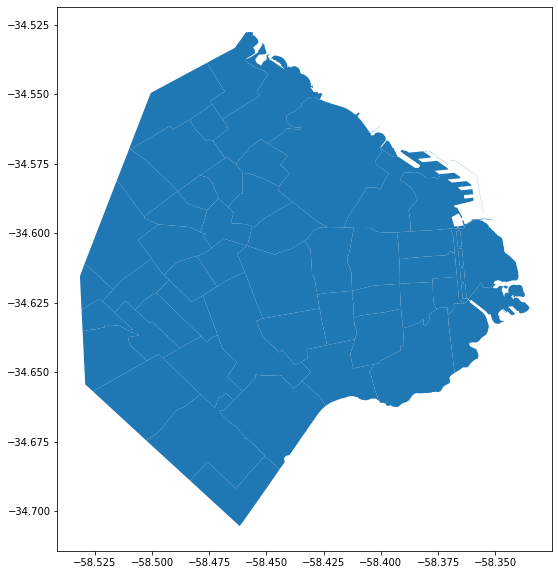

In [2]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax)


In [3]:
df = pd.read_csv('fourcorners.csv', ',')
epsg = 'epsg:22171'
df.head()

,dot,lat,lon
0,A,-34.534599,-58.531942
1,B,-34.534599,-58.334982
2,C,-34.705557,-58.334982
3,D,-34.705557,-58.531942


In [4]:
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geometry

In [5]:
geo_df = gpd.GeoDataFrame(df,
                         crs = epsg, 
                         geometry = geometry)
geo_df

,dot,lat,lon,geometry
0,A,-34.534599,-58.531942,POINT (-58.53194 -34.53460)
1,B,-34.534599,-58.334982,POINT (-58.33498 -34.53460)
2,C,-34.705557,-58.334982,POINT (-58.33498 -34.70556)
3,D,-34.705557,-58.531942,POINT (-58.53194 -34.70556)


<AxesSubplot:>

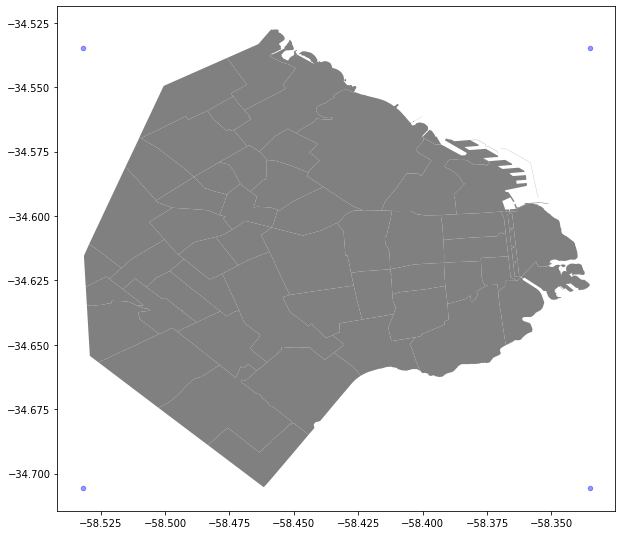

In [6]:
fig,ax = plt.subplots(figsize = (10,10))
bsas_map.plot(ax=ax, color='grey')
geo_df.plot(ax=ax, markersize=20, alpha=0.4, color='blue')

In [7]:
# Set up projections
p_ll = pyproj.Proj('epsg:4326') # epsg mundo
p_mt = pyproj.Proj('EPSG:3857') # epsg argentinta


In [8]:
import shapely
sw = shapely.geometry.Point((-58.538143, -34.705557))
ne = shapely.geometry.Point((-58.350345, -34.532787))

stepsize = 500 # 500 m grid step size

In [9]:
# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to 22177
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

In [ ]:
# Iterate over 2D area
gridpoints = []
x = transformed_sw[0]
while x < transformed_ne[0]:
    y = transformed_sw[1]
    while y < transformed_ne[1]:
        p = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, x, y))
        gridpoints.append(p)
        y += stepsize
    x += stepsize

In [ ]:
import csv

with open('testoutbsas.csv', 'w') as of:
    of.write('lon,lat\n')
    for p in gridpoints:
        of.write('{:f},{:f}\n'.format(p.x, p.y))

In [ ]:
df_coords = pd.read_csv('testoutbsas.csv', ',')
epsg = 'epsg:3857'
df_coords

In [ ]:
gdf = gpd.GeoDataFrame(
    df_coords, geometry=gpd.points_from_xy(df_coords.lat, df_coords.lon))

In [ ]:
gdf

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='grey')
gdf.plot(ax=ax, markersize=5, alpha=0.4, color='blue')

In [ ]:
import numpy as np


la grilla tiene 42x47

In [ ]:
grid = np.zeros((41,46))

In [ ]:
data = pd.read_json('backupPretty.json')
data

In [ ]:
data = data.T
data.head()

In [ ]:
data = data.drop(columns = ['user_longitude', 'user_latitude', '__collections__'])

In [ ]:
data = data[['search_longitude', 'search_latitude', 'arrive', 'leave','search_method', 'timestamp', 'uid']]

In [ ]:
data.reset_index(level=0, inplace=True) 

In [ ]:
data.rename(columns={"index": "search_track"})

In [ ]:
data['search_method'] = data['search_method'].convert_dtypes()

In [ ]:
data['search_method'].dtypes

In [ ]:
data["search_method"]

In [ ]:
data = data[data.search_method != 'startup']
data.head()

In [ ]:
gpd_data = gpd.GeoDataFrame(data,
                         crs = epsg, 
                         geometry = gpd.points_from_xy(data.search_longitude, data.search_latitude))
gpd_data.head(50)

In [ ]:
fig,ax = plt.subplots(figsize = (20,20))
bsas_map.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, markersize=5, color='black')
gpd_data.plot(ax=ax, markersize=5, color='red')
ax.set_xlim([-58.550, -58.325])
ax.set_ylim([-34.700, -34.525])


In [ ]:
grid_coordinates_gdf = gdf.copy()

In [ ]:
grid_coordinates_gdf['x'] = grid_coordinates_gdf['lat']
grid_coordinates_gdf['y'] = grid_coordinates_gdf['lon']
grid_coordinates_gdf.drop(columns = ['lat', 'lon'], inplace=True)

In [ ]:
grid_coordinates_gdf

In [ ]:
def coord_to_numsx(x):
    initial_x = 58.538143
    new_x = initial_x + x
    return new_x
    

def coord_to_numsy(y): 
    initial_y = 34.705557
    new_y = initial_y + y
    return new_y
    


In [ ]:
grid_coordinates_gdf["new_x"] = grid_coordinates_gdf["x"].map(coord_to_numsx)
grid_coordinates_gdf["new_y"] = grid_coordinates_gdf["y"].map(coord_to_numsy)


In [ ]:
grid_coordinates_gdf = pd.DataFrame(grid_coordinates_gdf)

grid_coordinates_gdf

In [ ]:
# fig,ax = plt.subplots(figsize = (20,20))
# grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
# # ax.set_xlim([0, 0.2])
# # ax.set_ylim([0,0.2])

In [ ]:
grid_coordinates_data = gpd_data.copy()
grid_coordinates_data

In [ ]:
grid_coordinates_data['x'] = grid_coordinates_data['search_longitude']
grid_coordinates_data['y'] = grid_coordinates_data['search_latitude']
grid_coordinates_data

In [ ]:
grid_coordinates_data["new_x"] = grid_coordinates_data["x"].map(coord_to_numsx)
grid_coordinates_data["new_y"] = grid_coordinates_data["y"].map(coord_to_numsy)
grid_coordinates_data = pd.DataFrame(grid_coordinates_data)

grid_coordinates_data

In [ ]:
fig,ax = plt.subplots(figsize = (15,15))
grid_coordinates_gdf.plot(ax=ax, color='black', x='new_x', y='new_y', kind='scatter')
grid_coordinates_data.plot(ax=ax, color='red', x='new_x', y='new_y', kind='scatter')
ax.set_xlim([0, 0.2])
ax.set_ylim([0,0.2])

In [ ]:
grid_coordinates_gdf.head(90)

In [ ]:
grid_coordinates_gdf.new_x.nunique()

In [ ]:

def data_in_gdf(x,y):
    
    x_column = x/0.002345
    y_column = y/0.004492
    
    return int(x_column), int(y_column)
    

In [ ]:
print(grid_coordinates_data.loc[[11778]])

In [ ]:
data_in_gdf(0.154728,0.113642)